# Licence and access rights notebook

## Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# %load imports.py
# Basic imports
import os
import sys

import matplotlib

sys.path.append('./')

# SQL database
import pymysql

# Classical external libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('classic')

import seaborn as sns
sns.set(style="darkgrid")

import typing
from datetime import date

In [3]:
from helpers import group_and_count, read_table, decade_from_year_df, multiple_ar_np, license_stats_table, \
np_by_property, filter_df_by_np_id, np_country, filter_df
from visualization import plot_licences
from sql import db_engine
from typing import Iterable

## Connection to DB

In [4]:
# Connexion database
engine = db_engine()

## Load Useful Data

In [5]:
newspapers_df = read_table('impresso.newspapers', engine)
issues_df = read_table('impresso.issues', engine)
# Create new decade column
issues_df = decade_from_year_df(issues_df)

In [6]:
newspapers_metadata_df = read_table('newspapers_metadata', engine)
meta_properties_df = read_table('meta_properties', engine)
PROPERTIES = meta_properties_df.name.unique()

## Number of issues by access right policy

In [7]:
issues_df.access_rights.unique()

array(['Closed', 'OpenPublic', 'OpenPrivate'], dtype=object)

In [8]:
issues_df.head(3)

,id,year,month,day,edition,access_rights,created,last_modified,is_damaged,s3_version,newspaper_id,decade
0,actionfem-1927-10-15-a,1927,10,15,a,Closed,2019-06-15 12:22:38,NaT,0,,actionfem,1920
1,actionfem-1927-11-15-a,1927,11,15,a,Closed,2019-06-15 12:22:38,NaT,0,,actionfem,1920
2,actionfem-1927-12-15-a,1927,12,15,a,Closed,2019-06-15 12:22:38,NaT,0,,actionfem,1920


In [9]:
count_issue_ar_df, _, _ = group_and_count(issues_df, ['access_rights'], 'id')

In [10]:
total_nb_issues = count_issue_ar_df['count'].sum()
count_issue_ar_df['rate'] = count_issue_ar_df['count']/total_nb_issues

In [11]:
count_issue_ar_df

,access_rights,count,rate
0,Closed,168685,0.381760
1,OpenPrivate,225703,0.510801
2,OpenPublic,47473,0.107439


On Oct. 15th 2019 : there are 225'703 open-private issues, 168'685 closed issues, and 47'473 open-public issues in the impresso db. <br/>
In other words, half issues (~51%) are open-private, around 38% are closed and finally only almost 11% of issues are open-public.

### Filter on property

#### By country

In [12]:
issues_df_select_ch = filter_df_by_np_id(issues_df, np_country('CH'))
issues_df_select_lux = filter_df_by_np_id(issues_df, np_country('LU'))

In [13]:
count_issue_ar_ch_df, _, _ = group_and_count(issues_df_select_ch, ['access_rights'], 'id')
count_issue_ar_lux_df, _, _ = group_and_count(issues_df_select_lux, ['access_rights'], 'id')

In [14]:
total_nb_issues_ch = count_issue_ar_ch_df['count'].sum()
total_nb_issues_lux = count_issue_ar_lux_df['count'].sum()

In [15]:
total_nb_issues_ch_lux = total_nb_issues_ch+total_nb_issues_lux

In [16]:
count_issue_ar_ch_df['ch_rate'] = count_issue_ar_ch_df['count']/total_nb_issues_ch

In [17]:
count_issue_ar_lux_df['lux_rate'] = count_issue_ar_lux_df['count']/total_nb_issues_lux

In [18]:
count_issue_ar_ch_df

,access_rights,count,ch_rate
0,Closed,112676,0.316981
1,OpenPrivate,225611,0.634691
2,OpenPublic,17179,0.048328


In [19]:
count_issue_ar_lux_df

,access_rights,count,lux_rate
0,Closed,56009,0.653814
1,OpenPublic,29656,0.346186


Looking at the country level is very interesting because we see that the access right of issues in both countries are very different.
- Switzerland : The percentage of open public issues is very low. Most issued (~63%) are open-private and the large majority of the rest (~32%) has closed access rights.
- Luxembourg : On the contrary, there are no open-private access right on issues. Approximately two thirds (65%) of the issues has closed access rights, and the last third has open-public access.

### Issues access rights at the level of newspapers

#### Insights on the newspapers which have several access right levels

In [20]:
np_multiple_ar = multiple_ar_np(issues_df)

In [21]:
print("The following papers have issues with different access rights : ")
np_multiple_ar

The following papers have issues with different access rights : 


array(['EXP', 'GDL', 'IMP', 'LCE', 'LSE', 'indeplux', 'luxwort',
       'waeschfra'], dtype=object)

In [22]:
count_issues_np_ar,_,_ = group_and_count(issues_df, ['newspaper_id', 'access_rights'], 'id')

In [23]:
count_issues_np_ar.head()

,newspaper_id,access_rights,count
0,BDC,OpenPublic,23
1,CDV,OpenPublic,1200
2,DLE,OpenPrivate,402
3,EDA,OpenPublic,544
4,EXP,OpenPrivate,46196


In [24]:
ar_df = filter_df_by_np_id(count_issues_np_ar, np_multiple_ar)

In [25]:
license_stats_table(ar_df)

access_rights,newspaper_id,Closed,OpenPrivate,OpenPublic,Total,rate_Closed,rate_OpenPrivate,rate_OpenPublic
0,EXP,0.0,46196.0,8.0,46204.0,0.000000,0.999827,0.000173
1,GDL,0.0,51062.0,8.0,51070.0,0.000000,0.999843,0.000157
2,IMP,0.0,40227.0,1.0,40228.0,0.000000,0.999975,0.000025
3,LCE,0.0,16291.0,1.0,16292.0,0.000000,0.999939,0.000061
4,LSE,0.0,20182.0,1.0,20183.0,0.000000,0.999950,0.000050
5,indeplux,16447.0,0.0,1903.0,18350.0,0.896294,0.000000,0.103706
6,luxwort,16027.0,0.0,14328.0,30355.0,0.527986,0.000000,0.472014
7,waeschfra,224.0,0.0,436.0,660.0,0.339394,0.000000,0.660606


Papers which have issues with several access rights can be grouped into three groups :
- Group 1 : Those for which almost 100% of their issues have the same access right level and for which other access right permissions are very rare. It is actually the case for all swiss newspapers which have several access rights : EXP, GDL, IMP, LCE and LSE. For the last three, only one issue among all has a different access right. We could investigate on whether this is an outlier and what it is due to. Note also that they all have the same access right majority : OpenPrivate (and minority : OpenPublic).
- Group 2 : Those for which most of their issues have the same access right level. It is the case for indeplux : almost 90% of its issues have access right Closed, whereas the left 10% are OpenPublic.
- Group 3 : Those for which the difference between the two access right levels is more balanced. It is the case for luxwort (53% closed vs 47% open public) and waeschfra (34% closed vs 66% open public). 

Based on these observations, we can investigate on the following questions :
- Where do the rare values in group 1 come from ? Errors from the dataset ? Particular issue-s ?
- Are the access right levels in group 2 and 3 linked to some other property of the issues or to the date in time ?

In [26]:
# TODO next : answer thw two questions above (and illustrate second one with plot in time if relevant)

### Plot

You can try a lot of things with this function and in particular add filters to focus on specific newspapers (by property, language, country, specific newspaper_ids). It is also possible to add a parameter 'batch_size' to limit the number of decades / np per plot.

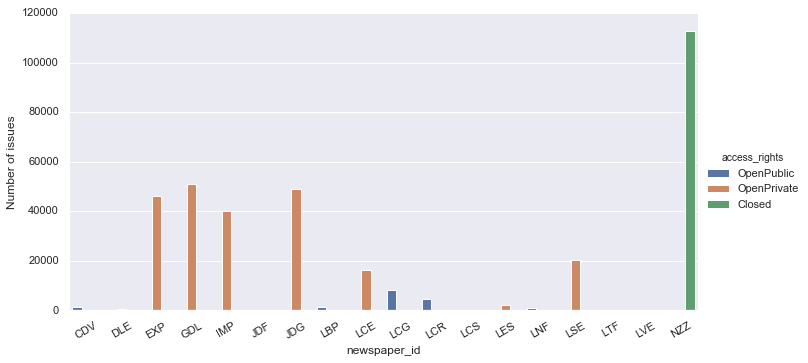

In [32]:
# newspaper_id dimension
plot_licences(facet='newspapers', df=issues_df, country='CH')

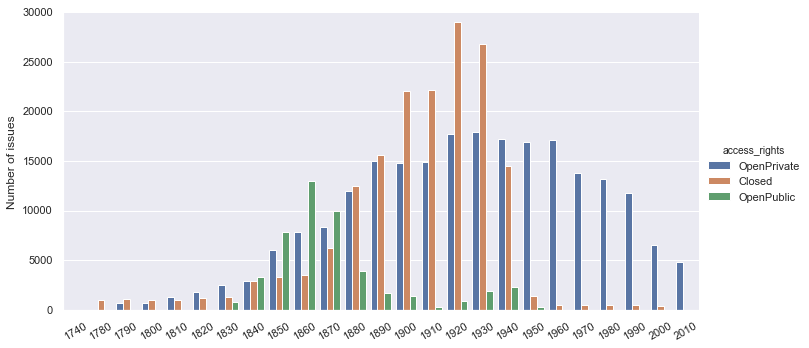

In [31]:
# time (decade) dimension
plot_licences(facet='time', df=issues_df)